In [21]:

import kagglehub
from numpy import dtype

dataset_path = kagglehub.dataset_download('sukhdayaldhanday/dream-11-fantasy-points-data-of-ipl-all-seasons')
# dataset_path = '/home/dev/.cache/kagglehub/datasets/sukhdayaldhanday/dream-11-fantasy-points-data-of-ipl-all-seasons/versions/1'

print('Data source import complete.')
dataset_path

Data source import complete.


'/home/dev/.cache/kagglehub/datasets/sukhdayaldhanday/dream-11-fantasy-points-data-of-ipl-all-seasons/versions/1'

In [22]:


import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler



In [69]:
class Data(Dataset):
    def __init__(self,xy,device):
        self.x = xy[0].to(device)
        self.y = xy[1].to(device)
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [100]:

class FantasyData(Dataset):
    def __init__(self,bat,bowl):

        self.batting , self.bowling = self.transform_data(self.join_data(bat,bowl))

    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    def join_data(self,batting,bowling):
        batting.drop(['bowling_team','batting_team','batting_innings' , 'batting_position'],axis=1,inplace=True)
        bowling.drop(['bowling_team','batting_team','bowling_innings' , 'total_balls', 'dots', 'maidens', 'conceded', 'foursConceded',
       'sixesConceded','wides', 'noballs', 'LBW',
       'Hitwicket', 'CaughtBowled', 'Bowled'],axis=1,inplace=True)
        return pd.merge(batting, bowling,  how='outer')
    def transform_data(self , df , bowling = True  , batting = True ):
        self.bowler_data = {}
        self.batter_data = {}
        df = df[df['season'] > 2015]

        batting_transformed_rows = []
        bowling_transformed_rows = []

        # Process each batter separately
        for player, group in df.groupby("fullName"):
            batting_prev = -1
            bowling_prev = -1
            # Sort the batter's matches in chronological order
            group = group.sort_values(["season", "match_id"]).reset_index(drop=True)
            # List to keep track of previous match scores for this batter
            batting_previous_scores = []
            bowling_previous_scores = []

            # Iterate over the batter's matches
            for i, row in group.iterrows():
                current_season = row["season"]
                num_matches = i

                if batting:
                    # Previous match score: last score in the list, if available
                    batting_prev_match_score = batting_previous_scores[-1] if batting_previous_scores else None

                    # Previous 5 matches average points: average of last 5 scores
                    last_five = batting_previous_scores[-5:] if batting_previous_scores else []
                    batting_prev_5_avg = sum(last_five) / len(last_five) if last_five else None

                    # Previous season average points: consider all matches of this batter with season < current_season
                    batting_prev_season_scores = group[group["season"] < current_season]["Batting_FP"].tolist()
                    batting_prev_season_avg = sum(batting_prev_season_scores) / len(batting_prev_season_scores) if batting_prev_season_scores else None

                    batting_row_dict = {
                    "Batter name": row["fullName"],
                    "batting_prev": batting_prev_match_score,
                    "batting_prev5": batting_prev_5_avg,
                    "batting_prevSSN": batting_prev_season_avg,
                    "num matches": num_matches,
                    "venue": row["venue"],
                    "season": current_season,
                    "Batting_FP" : row["Batting_FP"],
                    }
                # row_dict.extend(venue_encoding)

                    batting_transformed_rows.append(batting_row_dict)
                    batting_prev = batting_row_dict
                    batting_previous_scores.append(row["Batting_FP"])
                # Bowling Data


                if bowling:
                    bowling_prev_match_fp = bowling_previous_scores[-1] if bowling_previous_scores else None

                    # Previous 5 matches average Bowling_FP: average of last 5 scores
                    last_five = bowling_previous_scores[-5:] if bowling_previous_scores else []
                    bowling_prev_5_avg_fp = sum(last_five) / len(last_five) if last_five else None
                    num_matches = len(bowling_previous_scores)

                    # Previous season average Bowling_FP: consider all matches of this bowler with season < current_season
                    bowling_prev_season_scores = group[group["season"] < current_season]["Bowling_FP"].tolist()
                    bowling_prev_season_avg_fp = sum(bowling_prev_season_scores) / len(bowling_prev_season_scores) if bowling_prev_season_scores else None







                # Create the dictionary for the current row


                    bowling_row_dict = {
                        "Bowler name": row["fullName"],
                        "venue": row["venue"],
                        "bowling_prev": bowling_prev_match_fp,
                        "bowling_prev5": bowling_prev_5_avg_fp,
                        "bowling_prevSSN": bowling_prev_season_avg_fp,
                        "season": current_season,
                        "num matches": num_matches,
                        "Bowling_FP": row["Bowling_FP"],

                    }

                    bowling_transformed_rows.append(bowling_row_dict)
                    bowling_prev = bowling_row_dict

                    # Update the list of previous scores with the current match's Bowling_FP
                    bowling_previous_scores.append(row["Bowling_FP"])
            self.batter_data[player] = batting_prev
            self.bowler_data[player] = bowling_prev


        return pd.DataFrame(batting_transformed_rows),pd.DataFrame(bowling_transformed_rows)


    def get_batting_data(self,name,venue , season ):
        data = self.batter_data[name].copy()
        data["venue"] = [venue]
        data["season"] = [season]
        data = pd.DataFrame(data)
        data["Batting_FP"] = [0]*len(data)
        return self.preprocess_batting(data,False)

    def get_bowling_data(self,name,venue , season ):
        data = self.bowler_data[name].copy()
        data["venue"] = [venue]
        data["season"] = [season]
        data = pd.DataFrame(data)
        data["Bowling_FP"] = [0]*len(data)
        return self.preprocess_bowling(data,False)
    # Assumes transformed data
    def preprocess_batting(self, df , train = True  ):
        # Targets
        print(df.columns)
        y =  torch.tensor(
            df[["Batting_FP"]].fillna(0).values,
            dtype=torch.float32
        )

        # Compute sums for each column
        positive_sums = torch.sum(y * (y > 0), dim=0)  # Sum of positive values
        negative_sums = torch.sum(-y * (y < 0), dim=0)  # Sum of negative values

        # Avoid division by zero by adding a small epsilon
        epsilon = 1e-8
        scale_factors = positive_sums / (negative_sums + epsilon)
        scale_factors = scale_factors.unsqueeze(0) * 0.05  # Shape: (1, 4)

        # Apply scaling only to negative values (correct broadcasting)
        y = torch.where(y < 0, y * scale_factors, y)
        print(y.shape)






        # 2. One-hot encode teams
        if train :
            self.venue_enc = OneHotEncoder(sparse_output=False)
            venue = self.venue_enc.fit_transform(df[['venue']])
            print(self.venue_enc)
        else :

            print([[df['venue']]])
            venue = self.venue_enc.transform(df[['venue']])
            print(venue)


        # 3. Process season
        if train :
            self.scaler = MinMaxScaler()
            season_scaled = self.scaler.fit_transform(df[['season']])
        else :
            season_scaled = self.scaler.transform(df[['season']])

        # Convert to tensors and combine
        season_tensor = torch.tensor(season_scaled, dtype=torch.float32)
        venue_tensor = torch.tensor(venue, dtype=torch.float32)

        batting_prev = torch.tensor(df[["batting_prev"]].fillna(0).values, dtype=torch.float32)
        batting_prev5 = torch.tensor(df[["batting_prev5"]].fillna(0).values, dtype=torch.float32)
        batting_prevSSN = torch.tensor(df[["batting_prevSSN"]].fillna(0).values, dtype=torch.float32)
        if train:
            self.scaler_matches = MinMaxScaler()
            matches_scaled = self.scaler_matches.fit_transform(df[['num matches']].fillna(0))
        else:
            matches_scaled = self.scaler_matches.transform(df[['num matches']])

        num_matches = torch.tensor(matches_scaled, dtype=torch.float32)

        x = torch.cat([
            batting_prev,
            batting_prev5,
            batting_prevSSN,
            num_matches,
            season_tensor,
            venue_tensor,
        ], dim=1)
        # print(x.shape)

        return x,y
    def preprocess_bowling(self, df,train = True):


        # Targets (Bowling_FP)
        y = torch.tensor(
            df[["Bowling_FP"]].fillna(0).values,
            dtype=torch.float32
        )

        # Compute sums for scaling negative values
        positive_sums = torch.sum(y * (y > 0), dim=0)  # Sum of positive values
        negative_sums = torch.sum(-y * (y < 0), dim=0)  # Sum of negative values

        epsilon = 1e-8  # Avoid division by zero
        scale_factors = positive_sums / (negative_sums + epsilon)
        scale_factors = scale_factors.unsqueeze(0) * 0.05

        y = torch.where(y < 0, y * scale_factors, y)

        # One-hot encode venues
        if train:
            self.venue_enc = OneHotEncoder(sparse_output=False)
            venue_encoded = self.venue_enc.fit_transform(df[['venue']])
        else:
            venue_encoded = self.venue_enc.transform(df[['venue']])

        venue_tensor = torch.tensor(venue_encoded, dtype=torch.float32)

        # Scale seasons using MinMaxScaler
        if train:
            self.scaler = MinMaxScaler()
            season_scaled = self.scaler.fit_transform(df[['season']])
        else:
            season_scaled = self.scaler.transform(df[['season']])

        season_tensor = torch.tensor(season_scaled, dtype=torch.float32)


        bowling_prev_tensor = torch.tensor(df[["bowling_prev"]].fillna(0).values, dtype=torch.float32)
        bowling_prev5_tensor = torch.tensor(df[["bowling_prev5"]].fillna(0).values, dtype=torch.float32)
        bowling_prevSSN_tensor = torch.tensor(df[["bowling_prevSSN"]].fillna(0).values, dtype=torch.float32)
        if train:
            self.scaler_matches = MinMaxScaler()
            matches_scaled = self.scaler_matches.fit_transform(df[['num matches']].fillna(0))
        else:
            matches_scaled = self.scaler_matches.transform(df[['num matches']])

        season_tensor = torch.tensor(season_scaled, dtype=torch.float32)
        num_matches = torch.tensor(matches_scaled, dtype=torch.float32)

        # Combine all features into a single tensor (x)
        x = torch.cat([

            bowling_prev_tensor,
            bowling_prev5_tensor,
            bowling_prevSSN_tensor,
            num_matches,
            season_tensor,
            venue_tensor,
        ], dim=1)

        return x, y



In [101]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(28,128,bias=True)
        self.lin2 = nn.Linear(128,128,bias=True)
        self.lin3 = nn.Linear(128,64,bias=True)
        self.lin4 = nn.Linear(64,32,bias=True)
        self.lin5 = nn.Linear(32,1,bias=True)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self,x):
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        x = self.sigmoid(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.lin4(x)
        x = self.relu(x)
        x = self.lin5(x)
        # x = self.relu(x)
        return x



In [102]:
def train(model, train_data_loader, optimizer, loss_fn):
    total_loss = 0.0
    model.train()  # Set the model to training mode

    for data in train_data_loader:
        inputs, labels = data  # Unpack inputs and labels
        inputs = inputs.detach()
        labels = labels.detach()
        optimizer.zero_grad()  # Clear gradients from previous step

        outputs = model(inputs)  # Forward pass
        loss = loss_fn(outputs, labels)  # Compute loss

        loss.backward()  # Backward pass (no need for retain_graph=True)
        optimizer.step()  # Update weights

        total_loss += loss.item()  # Accumulate loss

    # Compute average loss over all batches
    avg_loss = total_loss / len(train_data_loader)

    return avg_loss


In [103]:
def evaluate(model, eval_data_loader ):
    model.eval()  # Set model to evaluation mode
    total_error = 0  # Assuming 4 output columns
    total_samples = 0

    with torch.no_grad():  # Disable gradient computation
        for data in eval_data_loader:
            inputs, labels = data
            inputs = inputs.detach()
            labels = labels.detach()

            # Forward pass
            outputs = model(inputs)

            # Calculate squared error for each sample and each output
            error = (outputs - labels)**2

            # Sum errors across batches
            total_error += error.sum(dim=0)
            total_samples += labels.size(0)

    # Calculate average error for each column
    avg_error = total_error / total_samples

    return torch.sqrt(avg_error)

In [104]:
batting = pd.read_csv(f'{dataset_path}/Batting_data.csv')
bowling = pd.read_csv(f'{dataset_path}/Bowling_data.csv')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = FantasyData(batting,bowling)
batting_data = Data(data.preprocess_batting(data.batting),device)
batting_train_data_loader = DataLoader(batting_data, batch_size=1024,shuffle=True)

criterion  = nn.MSELoss()
batting_model = Model().to(device)
optimizer = optim.AdamW(batting_model.parameters(), lr=0.01)
loss_list = []

Index(['Batter name', 'batting_prev', 'batting_prev5', 'batting_prevSSN',
       'num matches', 'venue', 'season', 'Batting_FP'],
      dtype='object')
torch.Size([10935, 1])
OneHotEncoder(sparse_output=False)


In [116]:
bowling_data = Data(data.preprocess_bowling(data.bowling),device)
bowling_train_data_loader = DataLoader(bowling_data, batch_size=1024,shuffle=True)
bowling_model = Model().to(device)

In [118]:
def training_loop(model, train_data_loader, optimizer, criterion = nn.MSELoss(), loss_list=[] ):
    epoch = 650
    count = 0
    prev = float('inf')
    model.train()
    for iter in range(epoch):

        avg_loss = train(model, train_data_loader, optimizer, criterion)

        if iter%20 ==0 :
            if prev<avg_loss:
                count+=1
             # , avg_loss , iter )
            prev = avg_loss
        if iter%100==0:
            print(avg_loss , iter )
            print(evaluate(model, train_data_loader))
        loss_list.append(avg_loss)
        if count > 30:
            break
    print(avg_loss)
    plt.plot(loss_list)
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    print(evaluate(model, train_data_loader))


734.0319935191761 0
tensor([24.8830])
484.20279208096593 100
tensor([21.5858])
375.4730502041903 200
tensor([19.1947])
308.4139612371271 300
tensor([17.0148])
256.5311931263317 400
tensor([15.6956])
227.31254993785512 500
tensor([14.4876])
221.18834339488637 600
tensor([14.1196])
195.62422735040838


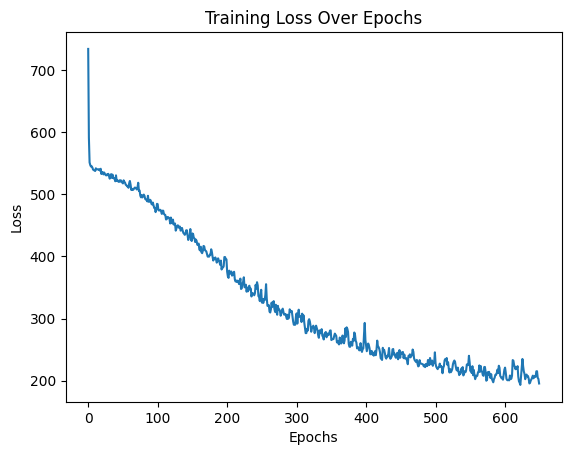

tensor([13.7538])


In [119]:
training_loop(bowling_model, bowling_train_data_loader, optim.AdamW(bowling_model.parameters(), lr=0.01))

In [114]:
# evaluate(model, batting_train_data_loader)
torch.save(bowling_model.state_dict(), "models/bowling_new.pth")

In [84]:
# model.load_state_dict(torch.load("models/batting_new.pth"))

<All keys matched successfully>

In [122]:
evaluate(bowling_model , DataLoader([data.get_bowling_data("Virat Kohli",'M.Chinnaswamy Stadium, Bengaluru',2023)  ]))

tensor([[1.2161]])

tensor([10.4129])

array(['Narendra Modi Stadium, Motera, Ahmedabad',
       'Punjab Cricket Association IS Bindra Stadium, Mohali, Chandigarh',
       'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow',
       'Rajiv Gandhi International Stadium, Uppal, Hyderabad',
       'M.Chinnaswamy Stadium, Bengaluru',
       'MA Chidambaram Stadium, Chepauk, Chennai',
       'Arun Jaitley Stadium, Delhi',
       'Barsapara Cricket Stadium, Guwahati', 'Eden Gardens, Kolkata',
       'Wankhede Stadium, Mumbai', 'Sawai Mansingh Stadium, Jaipur',
       'Himachal Pradesh Cricket Association Stadium, Dharamsala',
       'Brabourne Stadium, Mumbai',
       'Dr DY Patil Sports Academy, Navi Mumbai',
       'Maharashtra Cricket Association Stadium, Pune',
       'Dubai International Cricket Stadium', 'Sharjah Cricket Stadium',
       'Sheikh Zayed Stadium, Abu Dhabi',
       'Dr. Y.S. Rajasekhara Reddy ACA-VDCA Cricket Stadium, Visakhapatnam',
       'Holkar Cricket Stadium, Indore',
       'Saurashtr